<img src="Branded_Logo_CUDenver.PNG" width="150">

## <center>CSCI 4580/5580 – Data Science – Spring 2025</center>
<center>Lab 4: NLP</center><center><font color='red'>Deadline: March 7, 2025 - 11:59 PM</font></center><center>Total Points: 100</center>

## Instructions
- Please note that this assignment must be done individually. By submitting this lab, you certify that this is your own work, your code will be checked against other submissions and resources using automatic tools. Everyone should be getting a hands on experience in this course. You are free to discuss course material with fellow students, and we encourage you to use Internet resources to aid your understanding, but the work you turn in, including all code and answers, must be your own work.

## Deliverables
You need to submit a single .ipynb file on Canvas, names your-lastname_your-first-name.ipynb. For example, if your name is John Smith, you should name the file smith_john.ipynb.
- Please do not include extra files such as the input datasets in your submission.
- Answer Questions 1 - 3 in the designated cells. Please do not add or remove any cells. 
- Please download your submission file after submission and make sure it is not corrupted. Use the 'Run All' option from the 'Cell' menu to ensure all cells run without any issues. We will not be responsible for corrupted submissions and will not take a resubmission after the deadline.

## Need Help?
If you need help with this lab, please email me at sundous.hussein@ucdenver.edu or come to my office hours. We also encourage you to ask your questions on the designated channel for the lab on Microsoft Teams. This way, you may receive assistance from your classmates that might’ve ran through the same issues.

In this lab we'll explore NLP with the Stanford Parsing suite.

## NOTE:
The Stanford Parser requires the Ubuntu virtual machine that you created in lab 0. If you didn’t complete lab 0, please refer to the instructions there to install the required tools before continuing with this lab. 

# Natural Language Analysis of Content

Here we're going to use a parser to extract some "facts" from natural language. The text is from the simplified wikipedia site: http://simple.wikipedia.org. It has been filtered to find sentences about cats. Download the <b>cats.txt</b> file from Canvas. 

## Stanford Parser Setup

Download the Stanford parser from Canvas and unpack it using the following command:

<pre>tar xvzf stanfordparser.tar.gz</pre>

and then move it to the /opt directory with

<pre>sudo mv StanfordParser /opt</pre>

It will be helpful to have links to the parser scripts from your bin directory. 
<pre>
cd ~/bin
ln -s /opt/StanfordParser/lexparser.sh lexparser.sh
ln -s /opt/StanfordParser/lexparser-gui.sh lexparser-gui.sh
ln -s /opt/StanfordParser/dependencyviewer/dependencyviewer.sh dependencyviewer.sh
</pre>

These files will be in your path the next time you login. You can logout from the start button at the top right of the VM window. Then log back in again.    

## Running the Parser

From a terminal window, type

<pre>lexparser-gui.sh</pre> 
or alternatively 
<pre>~/bin/lexparser-gui.sh</pre>
 **NOTE: if java is not already installed, you can install it with:**
  <pre>sudo apt install default-jre</pre>
 

This brings up a GUI interface to the Stanford parser. To use it, click on "Load Parser" which brings up a file selection dialog. Navigate to

<pre>/opt/StanfordParser/stanford-parser-3.4.1-models.jar</pre>

and open it.

Then you will see a list of parsers to use. Select

<pre>englishPCFG.ser.gz</pre>

You're now ready to parse some text!

Click on the "Load File" button, and load the cats.txt file. Click on "Parse" to parse the current sentence (highlighted in yellow).

### NOTE:
The tags used by the parser are explained in more detail [here](https://gist.github.com/nlothian/9240750). The important parts of speech will be noun, verb, and subject. 


> Question 1) Generate two parse tree visualizations for any pair of sentences from cats.txt. The tree should show up in the bottom panel of the Stanford Parser when you click Parse. Screenshot the trees and insert the images below. Breifly reflect on the similarity/difference in structure between the two parse trees (for example: how are the parts of speech ordered, is one tree deeper/wider than the other, do the sentences seem like they should have similar/different trees but dont and why?) Make sure to submit the image files along with you notebook when you turn it in.

#### Add Question 1 answer here:
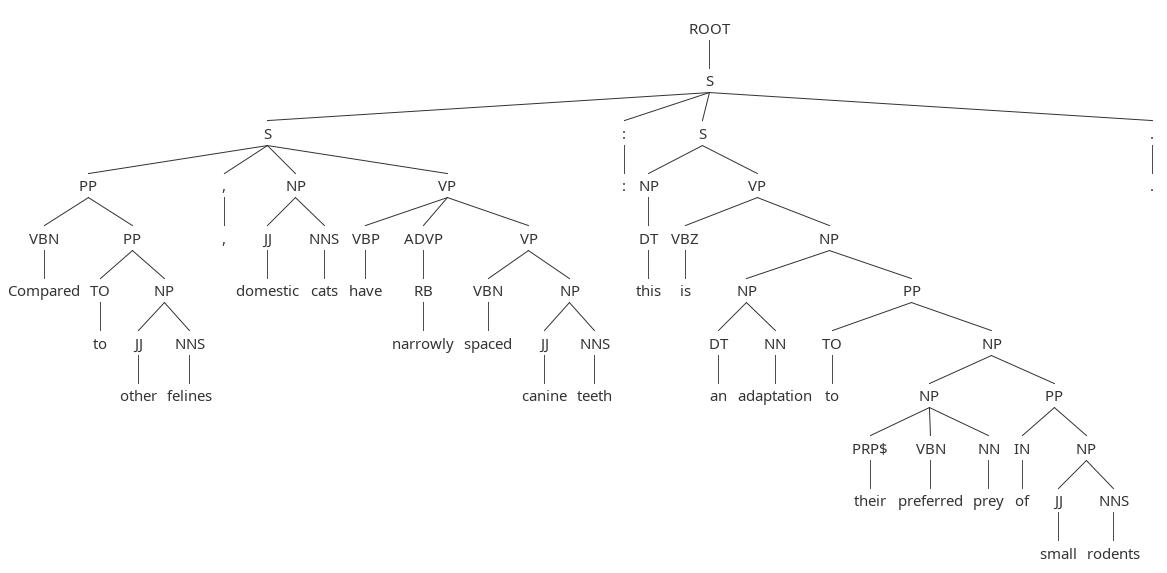
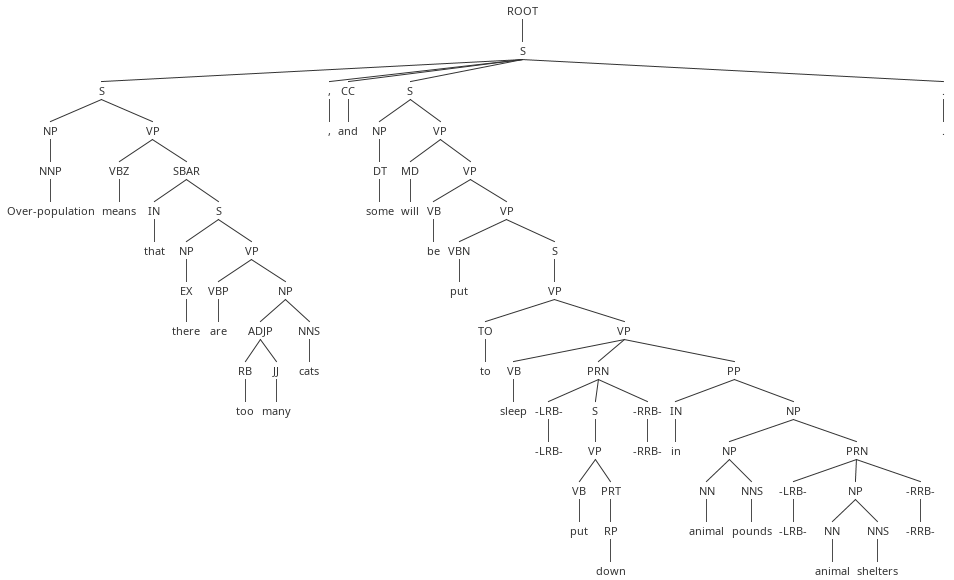

The first sentence compares two things using 'compared', while the second sentence connects two NP tags with an 'and'. This makes sense when visualizeing the POS ordering, where a NP tag doesn't appear first in the second sentence. The two structures are relatively similar in width, however, the second tree is much deeper. This, in part, is due to the LRB and RRB tags used to clarify meaning of words. With this said, the sentences aren't similar in meaning.

## Parsing to XML

We'll parse the cats sentence file to XML. To do this, we'll make a customized version of the parser script. Copy the file:

<pre>/opt/StanfordParser/lexparser.sh</pre>

and save it as:

<pre>/opt/StanfordParser/parsetoxml.sh</pre>

Edit it so that its outputFormat is:

<pre>-outputFormat "xmlTree"</pre>

and add a new option:

<pre>-outputFormatOptions "xml"</pre>

and create an alias to parsetoxml.sh it in your ~/bin directory.
<pre>cd ~/bin</pre>
<pre>ln -s /opt/StanfordParser/parsetoxml.sh parsetoxml.sh</pre>

Now run from your lab4 directory

<pre>parsetoxml.sh cats.txt > cats.xml</pre>

you're ready now to analyze the cats data. We'll use Python's built-in ElementTree parser.

## Working with the XML

You can now copy the cats.xml file out of the VM and into the same directory as this notebook.

In [1]:
from lxml import etree
parser = etree.XMLParser(recover=True)
tree = etree.parse('cats.xml',parser)

We can examine the root of this tree:

In [2]:
root=tree.getroot()
root.tag

'corpus'

In [3]:
len(root)

213

In [4]:
root[0].tag

's'

i.e. we have found the first sentence. The xmlTree representation is a little tricky however, as POS tags are stored as attributes of nodes rather than node tags. To get to the actual root node, we need to dig a little deeper (and we'll use the second sentence which is a bit more conventional):

In [5]:
root[1][0][0].attrib['value']

'ROOT'

going down one level gets us to the actual sentence node:

In [6]:
s=root[6][0][0][0]
s.attrib['value']

'S'

and to get its children we can do:

In [7]:
s[:]

[<Element node at 0x7c0cdc101680>,
 <Element node at 0x7c0cdc101880>,
 <Element node at 0x7c0cdc1018c0>]

This is not too helpful, because the node types are hidden in the value attributes of these nodes. To see them, we can use a python anonymous function and map it over the list.

In [8]:
list(map(lambda x: x.attrib['value'], s[:]))
# or if you prefer list comprehensions: nodes = [x.attrib['value'] for x in s[:]]

['NP', 'VP', '.']

Now let's see if we can find sentences starting with noun phrases containing a given noun. The final function supports a flexible syntax (similar to xpath) for locating elements of given type or attributes. A slash "/" is like a directory specifier, and defines a child node. A double slash "//" specifies any descendent, child, grandchild, great-grandchild, etc. The "node[@value='NP']" specifies a node with the given attribute value.

In [9]:
agent = s.findall("./node[@value='NP']//node[@value='NN']//leaf[@value='cat']")
agent[0].attrib

{'value': 'cat'}

finds all the nodes starting with an 'NP' child of s, and having a 'NN' node above a leaf with 'cat' value.

We can similarly look for a verb in a verb phrase under the root node:


In [10]:
verb = s.findall("./node[@value='VP']//node[@value='VBZ']//leaf[@value='is']")
verb[0].attrib

{'value': 'is'}

Putting these together, we can discover sentences containing a given pair of (agent,action) pairs:

In [11]:
def printnode(node):
    for i in node.findall(".//leaf"):
        print(" " + i.attrib['value']),
    print('')

def testnode(node, agent, action):
    aa = node.findall("./node[@value='NP']//node[@value='NN']//leaf[@value='"+agent+"']")
    bb = node.findall("./node[@value='VP']//leaf[@value='"+action+"']")
    if (len(aa) > 0 and len(bb) > 0):
        printnode(node)    

def agentact(node, agent, action):
    testnode(node, agent, action)
    snodes = node.findall(".//node[@value='S']")
    for snode in snodes:
        testnode(snode, agent, action)

In [12]:
title = 'cat'
agentact(s, title, 'is')

 A
 young
 cat
 is
 called
 a
 kitten
 .



Next we can apply the agentact function to all the sentences in the Wikipedia entry

In [13]:
[agentact(nn[0][0][0], title, 'is') for nn in root]
[] # hide the return bvalue

 A
 young
 cat
 is
 called
 a
 kitten
 .

 An
 entire
 female
 cat
 is
 a
 queen

 an
 entire
 male
 cat
 is
 a
 tom.Entire
 means
 a
 female
 cat
 that
 is
 not
 spayed
 ,
 and
 a
 male
 cat
 that
 is
 not
 neutered
 ,
 leaving
 either
 able
 to
 reproduce

 The
 word
 `
 cat
 '
 is
 also
 used
 for
 other
 felines
 .

 The
 cat
 skull
 is
 unusual
 among
 mammals
 in
 having
 very
 large
 eye
 sockets
 and
 a
 powerful
 and
 specialized
 jaw
 .

 Behaviour
 thumb
 |
 right
 |
 200px
 |
 The
 cat
 on
 the
 right
 is
 fed
 up
 with
 the
 cat
 on
 the
 left

 The
 cat
 creeps
 towards
 a
 chosen
 victim
 ,
 keeping
 its
 body
 flat
 and
 near
 to
 the
 ground
 so
 that
 it
 can
 not
 be
 seen
 easily
 ,
 until
 it
 is
 close
 enough
 for
 a
 rapid
 dash
 or
 pounce
 .

 a
 cat
 is
 relaxed

 a
 male
 cat
 's
 penis
 has
 a
 band
 of
 about
 120-150
 backwards-pointing
 spines
 ,
 which
 are
 about
 one
 millimeter
 long
 ;
 upon
 withdrawal
 of
 the
 penis
 ,
 the
 spines
 rake
 the
 wa

[]

> Question 2) Copy the code from the previous cell to the next cell and change the verb to something other than "is" that returns a few sentences. Can you find any sentences that share similar meaning based on their verb alone? Or completely different meaning? Write a breif sentence in a comment about what this could mean for an NLP model and the importance of having enough data.

> Question 3) Finish the testnode2 function that returns sentences in which the given adjective (JJ) appears in the cell below, you will need to check for plural nouns (NNS) in addition to singular nouns, which requires a new search with a leaf node of "cats"instead of "cat". Try a few different adjectives (ex: wild, domestic, brown, etc.). Not all adjectives will return results, and you can always check the parse tree in the Stanford parser to check for available adjective-noun pairs. Do the sentences you see make sense? Now try the adjective "dry". Is cat/cats still the subject of the sentences you see returned, if not what is the subject of the sentence? Does this suggest anything to you about how the nuances of languages and how they should be modeled? Write 2-3 sentences in a comment about your observations.


In [14]:
# Add Question 2 code here
[agentact(nn[0][0][0], title, 'fed') for nn in root]
[] # hide the return bvalue

 a
 cat
 live
 much
 longer
 compared
 to
 hunting
 or
 being
 fed
 table
 scraps

 Behaviour
 thumb
 |
 right
 |
 200px
 |
 The
 cat
 on
 the
 right
 is
 fed
 up
 with
 the
 cat
 on
 the
 left

 the
 cat
 is
 not
 fed
 a
 daily
 diet
 of
 dog
 food



[]

Two of the sentences are relatively similar, as they talk about what a cat is 'fed', regarding their diet. However, the other sentence is not similar to either because it uses a different meaning of the word 'fed', specifically meaning annoyed by 'fed up'. This is worth keeping in mind because some words have several different meanings, which can create noise when attempting to analyze certain words. However, many verbs I attempted didn't return more than one sentence, which would make a larger set of data optimal. With this said, more data introduces more noise and issues associated as previously touched on.

In [15]:
def testnode2(node, agent, modifier):
    aa = node.findall("./node[@value='NP']//node[@value='JJ']//leaf[@value='"+modifier+"']") 
    bb = node.findall("./node[@value='NP']//node[@value='NN']//leaf[@value='"+agent+"']") +\
         node.findall("./node[@value='NP']//node[@value='NNS']//leaf[@value='"+(f'{agent}s')+"']")

    if (len(aa) > 0 and len(bb) > 0):
        printnode(node)   
        
def agentact2(node, agent, modifier):
    testnode2(node, agent, modifier)
    snodes = node.findall(".//node[@value='S']")
    for snode in snodes:
        testnode2(snode, agent, modifier)
        
list(map(lambda nn: agentact2(nn[0][0][0], title, 'brown'), root))
[]

[]

The sentences I tested seemed to make sense. 'Dry' didn't return anything, and when I looked to the cat.xml file, it makes sense because dry is applied to food and not cat in the phrase 'dry cat food'. This is worth emphasizing because in some implementations dry would be applied to cat, even though that cat is not the subject, but rather food. Language is nuanced and models should accurately reflect what is being described by an adjective, especially when the thing being described isn't the word directly after. 